<a href="https://colab.research.google.com/github/BessieXuOrange/Data-Analysis/blob/main/Marketing_Campaign_A_B_Testing_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A/B Testing Scenario - Means**

The search team at Amazon conducts an experiment aimed at assessing the effectiveness of a new sponsored search ranking algorithm. This algorithm's purpose is to enhance the precision of product suggestions for customers. How would you evaluate the effectiveness of the new sponsored search ranking algorithm?

# **Part I: Upload Data and Turn Data into DF**


In [ ]:
import io
import pandas as pd
from google.colab import files
from statsmodels.stats.power import ttest_power, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
#upload csv
#use the following library
#from google.colab import files

uploaded = files.upload()

Saving historical_daily_sales.csv to historical_daily_sales.csv


In [ ]:
#turn csv to dataframe

#use the following library
#import pandas as pd
#import io

daily_user_sales = pd.read_csv(io.BytesIO(uploaded['historical_daily_sales.csv']))
print(daily_user_sales.head())

     DATE  USER_ID  SALES
0  6/1/23        3   5.89
1  6/1/23       79  13.08
2  6/1/23       75   6.88
3  6/1/23       76   7.63
4  6/1/23      100   3.50


# **Part II: Power Analysis to Calculate Sample Size for the Test**

In [ ]:
#calculate mean and std for power analysis

summary = pd.DataFrame(daily_user_sales.groupby('USER_ID')['SALES'].sum())
print(summary.head())

#Usually, we use last 28-30 days data as the base to calculate mean and sd
sd_sales = summary['SALES'].astype('float').std()
average_sales = summary['SALES'].astype('float').mean()

#print results
print ("sd_sales: " + str(sd_sales))
print ("avg_sales: " + str(average_sales))

         SALES
USER_ID       
1         7.63
2         6.49
3        13.52
4         7.24
5        13.88
sd_sales: 13.921136358018183
avg_sales: 11.123264900662253


In [ ]:
#use the following library
#from statsmodels.stats.power import ttest_power, tt_ind_solve_power - for mean calculation
#import statsmodels.api as sm - for proportion calculation

#two-sided t test for power analysis estimate - calculate sample size

# Power Analysis Input Parameters
MDE = 0.05 #Empirical threshold
significance_level = 0.05 #industry standard
power = 0.8 #industry standard
delta = average_sales*MDE
effect_size = delta/sd_sales #cohen D: effect_size for means

#effect_size for proportions
#effect_size = sm.stats.proportion_effectsize(average_ctr, average_ctr*(1+MDE))

# calculate for equal sample size, output is for one sample size
sample_size = tt_ind_solve_power(effect_size=effect_size,
                                 alpha=significance_level,
                                 power=power,
                                 ratio=1,
                                 alternative='two-sided',nobs1 = None)

## show sample size needed to achieve minimum power
print ("sample size needed for each group of the AB test: " + str(sample_size))
print ("sample size needed for the AB test: " + str(sample_size*2))

# calculate for unequal sample size - usually used for incrementality test
sample_size = tt_ind_solve_power(effect_size=effect_size,
                                 alpha=significance_level,
                                 power=power,
                                 ratio=9,
                                 alternative='two-sided',nobs1 = None)

## show total sample size needed to achieve minimum power
print ("sample size needed for an unequal test: " + str(sample_size*9+sample_size))

sample size needed for each group of the AB test: 9836.120217090216
sample size needed for the AB test: 19672.240434180432
sample size needed for an unequal test: 54641.69725303741


The tt_ind_solve_power() function requires the following parameters to calculate sample size:

effect_size: The standardised effect size ie. difference between the two means divided by the standard deviation; this value has to be positive. (This is different to R’s delta parameter, which requires the mean difference only.)
alpha: Significance level or probability of Type I error (false positives), usually set at 0.05.
power: Power of the test, or 1 – probability of Type II error (false negatives), usually set at 0.8.
ratio: Ratio of sample size in sample 2 relative to sample 1, default set at 1. (This function can be used to calculate power for unevenly-sized samples.)
alternative: Power the test to detect two-sided effects (eg. the effect could be an increase or a reduction in outcome, not forced to be only an increase in outcome.)

for sd in [0.4, 0.5, 0.6]:
n = tt_ind_solve_power(effect_size=mean_diff/sd, alpha=0.05, power=0.8, ratio=1, alternative='two-sided')
print('Number in *each* group when SD is {:<4.1f}: {:.2f}'.format(sd, n))

# **Part III: Calculate Test Duration**

In [ ]:
#upload csv

uploaded = files.upload()

Saving historical_daily_users.csv to historical_daily_users.csv


In [ ]:
daily_users = pd.read_csv(io.BytesIO(uploaded['historical_daily_users.csv']))
print(daily_users)

          DATE  USER_ID  AD_SPEND
0       6/1/23        3      4.42
1       6/1/23       79      9.81
2       6/1/23       75      5.16
3       6/1/23       76      5.72
4       6/1/23      100      2.63
...        ...      ...       ...
17983  6/30/23    16631      5.99
17984  6/30/23    16632      2.86
17985  6/30/23    16633      2.77
17986  6/30/23    16634      6.22
17987  6/30/23    16635      2.87

[17988 rows x 3 columns]


In [ ]:
#Calculate test duration

#casting date column
daily_users['DATE']=pd.to_datetime(daily_users['DATE'])

# Group by 'DATE' and count unique 'USER_ID'
daily_unique_users = daily_users.groupby('DATE')['USER_ID'].nunique()

#get the average daily user count
avg_daily_unique_users = daily_unique_users.mean()

#calculate test duration based on sample size
test_duration = sample_size*2/avg_daily_unique_users
print("Based on the last 30 days data, the average daily users is: ",avg_daily_unique_users)
print("Based on the last 30 days data, the calculated test duration is: ", test_duration)

#we usually want to make the test duration to be full weeks, in this case, test duration is 21 days.
ajusted_test_duration = math.ceil(test_duration/7)*7
print("Based on the last 30 days data, the adjusted test duration is: ", ajusted_test_duration)

Based on the last 30 days data, the average daily users is:  597.6666666666666
Based on the last 30 days data, the calculated test duration is:  18.285007446638286
Based on the last 30 days data, the adjusted test duration is:  21


# **Part IV: Calculate Budget Needed for the Test**

In [ ]:
#Linear estimation of spend required
#budget needed = sample size required*cost per user <- cost to reach unique eligible user
#Incremental budget = budget needed - current budget

#calculate variables
total_users = daily_users['USER_ID'].nunique()
total_spend = daily_users['AD_SPEND'].sum()
cost_per_user = total_spend/total_users
print("Based on the last 30 days data, cost/user is: ", cost_per_user)

#back up to sample size
total_spend_needed = sample_size*2*cost_per_user
daily_spend_needed = total_spend_needed/test_duration

print ('total spend needed for the test:' + f'{total_spend_needed:.2f}')
print ('daily spend needed for the test:' + f'{daily_spend_needed:.2f}')

Based on the last 30 days data, cost/user is:  6.3881389452332655
total spend needed for the test:69811.75
daily spend needed for the test:3817.98


# **Part V: Validity Test - AA Test**

In [ ]:
#upload csv

uploaded = files.upload()

Saving pretest_data.csv to pretest_data.csv


In [ ]:
#turn csv to dataframe

pretest_aa = pd.read_csv(io.BytesIO(uploaded['pretest_data.csv']))
print(pretest_aa)

       USER_ID     DATE EXPERIMENT  GROUP  SALES
0       169902   7/1/23    AA_test      0   3.46
1       169906   7/1/23    AA_test      0   5.58
2       169913   7/1/23    AA_test      1   6.49
3       169914   7/1/23    AA_test      0   7.58
4       169917   7/1/23    AA_test      0   0.41
...        ...      ...        ...    ...    ...
30034   309891  7/14/23    AA_test      1   5.46
30035   309893  7/14/23    AA_test      0   0.30
30036   309894  7/14/23    AA_test      0   9.05
30037   309895  7/14/23    AA_test      1   6.15
30038   309900  7/14/23    AA_test      0   9.58

[30039 rows x 5 columns]


In [ ]:
# Group by test groups, and calculate the average sales for each group
AA_avgsales_per_group = pretest_aa.groupby(['GROUP'])['SALES'].mean().reset_index()

print(AA_avgsales_per_group)

   GROUP     SALES
0      0  5.010678
1      1  4.999514


In [ ]:
#Use the following library
#import statsmodels.stats.api as sms

# Assuming df_aa_test_prep is your DataFrame containing the data

x = pretest_aa.loc[pretest_aa['GROUP'] == 0, 'SALES'].astype(float)
y = pretest_aa.loc[pretest_aa['GROUP'] == 1, 'SALES'].astype(float)

# Calculate CI of the means
cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
lb, ub = cm.tconfint_diff(usevar='unequal')

def hypothesis_test_output(lb, ub):
    if 0 > float(lb) and 0 < float(ub):
        return 'The two samples are not statistically different'
    else:
        return 'The two samples are statistically different'

result = hypothesis_test_output(lb, ub)
print(result)

#proportions can use the same method or use chi-squared test

The two samples are not statistically different


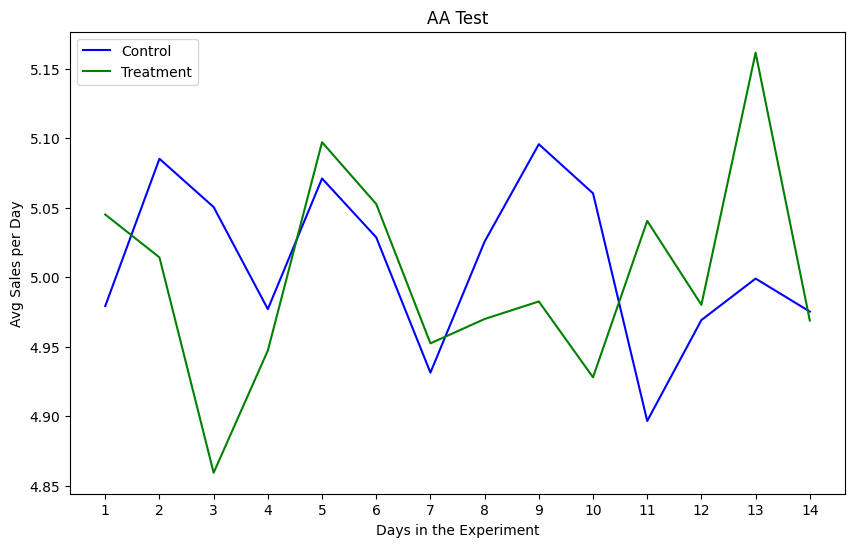

In [ ]:
#Use the following library
#import matplotlib.pyplot as plt

# average sales per user per day
AA_avg_sales_per_day = pretest_aa.groupby(['GROUP','DATE'])['SALES'].mean()
AA_ctrl_avg_sales = AA_avg_sales_per_day.loc[0]
AA_trt_avg_sales = AA_avg_sales_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, pretest_aa['DATE'].nunique() + 1)

# Let's display the avg sales per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_avg_sales, label='Control', color='b')
ax.plot(exp_days, AA_trt_avg_sales, label='Treatment', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA Test')
ax.set_ylabel('Avg Sales per Day')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# **Part VI: Validity Test - SRM Test (Sample Ratio Mismatch)**

In [ ]:
#upload csv

uploaded = files.upload()

Saving abtest_result.csv to abtest_result.csv


In [ ]:
test_result = pd.read_csv(io.BytesIO(uploaded['abtest_result.csv']))
print(test_result)

       USER_ID     DATE EXPERIMENT  GROUP  SALES
0           15   8/1/23    ab_test      0   6.07
1          356   8/1/23    ab_test      0   6.43
2          630   8/1/23    ab_test      0   4.89
3          892   8/1/23    ab_test      0   6.98
4         1312   8/1/23    ab_test      0   1.65
...        ...      ...        ...    ...    ...
18601   138743  8/21/23    ab_test      1   2.15
18602   138993  8/21/23    ab_test      1   3.58
18603   139347  8/21/23    ab_test      1   3.69
18604   139694  8/21/23    ab_test      1   4.34
18605   139976  8/21/23    ab_test      1   2.45

[18606 rows x 5 columns]


In [ ]:
#Use the following library
#import scipy.stats as stats

# Set test parameter
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
observed = test_result.groupby('GROUP')['USER_ID'].nunique().values
expected = test_result['USER_ID'].nunique()*0.5 #half of total test users

print("Observed Counts:", observed)
print("Expected Count:", expected)

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

Observed Counts: [9240 9366]
Expected Count: 9303.0
------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 0.853 | P-value = 0.356

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


# **Part VII: Validity Test - Novelty Effect**
Usually in user-visible test, for example, logo, new onboarding process, buttons etc.

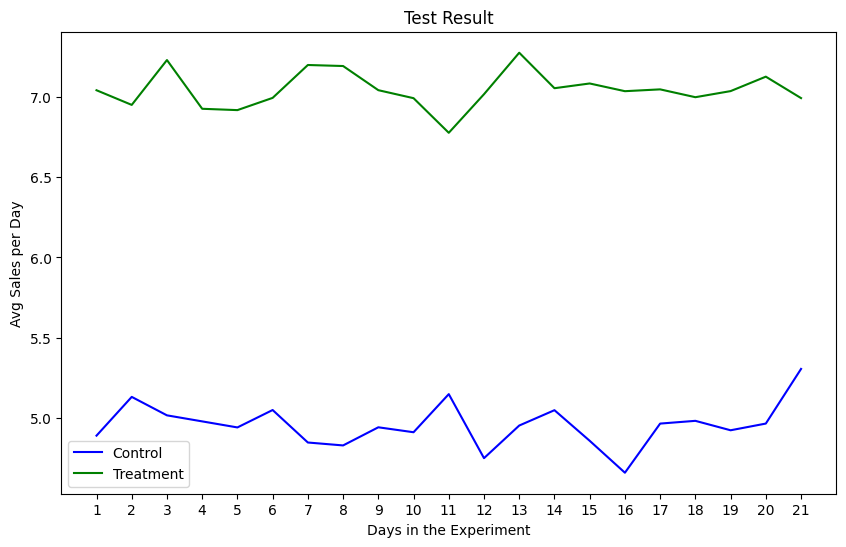

In [ ]:
#Use the following library
#import matplotlib.pyplot as plt

# average sales per user per day
avg_sales_per_day = test_result.groupby(['GROUP','DATE'])['SALES'].mean()
ctrl_avg_sales = avg_sales_per_day.loc[0]
trt_avg_sales = avg_sales_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, test_result['DATE'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, ctrl_avg_sales, label='Control', color='b')
ax.plot(exp_days, trt_avg_sales, label='Treatment', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('Test Result')
ax.set_ylabel('Avg Sales per Day')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# **Part VIII: Conduct Statistical Inference**

In [ ]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

# Grab the control and treatment avg_sales_per_user in the AB test
AB_control = test_result[test_result.GROUP == 0].groupby('USER_ID')['SALES'].mean()
AB_treatment = test_result[test_result.GROUP == 1].groupby('USER_ID')['SALES'].mean()
print(AB_control.head())
print(AB_treatment.head())

# Analyze Statistics
AB_tstat, AB_pvalue, AB_df = ttest_ind(AB_control, AB_treatment) #two arrays

# Print results
print('Ho: The avg. sales per user between test and control are the same.')
print('Ha: The avg. sales per user between test and control are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
 print('Reject Ho and conclude that there is statistical significance in the difference of avg. sales per user between test and green control.')
else:
  print('Fail to reject Ho.')

USER_ID
15    6.07
34    4.42
63    2.90
67    9.57
70    7.32
Name: SALES, dtype: float64
USER_ID
18     4.19
19    10.52
40    11.59
54     9.63
57     9.30
Name: SALES, dtype: float64
Ho: The avg. sales per user between test and control are the same.
Ha: The avg. sales per user between test and control are different.

Significance level: 0.05
T-Statistic = -49.198 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of avg. sales per user between test and green control.


In [ ]:
# Get stats
AB_control_sales = AB_control.sum()
AB_treatment_sales = AB_treatment.sum()
AB_control_avgsales = AB_control.mean()
AB_treatment_avgsales = AB_treatment.mean()
AB_control_size = AB_control.count()
AB_treatment_size = AB_treatment.count()

In [ ]:
#Use the following library
#import numpy as np
#import statsmodels.api as sm
#import statsmodels.stats.api as sms

# Create two descriptive statistics objects using test and control data
desc_stats_test = sm.stats.DescrStatsW(AB_treatment)
desc_stats_control = sm.stats.DescrStatsW(AB_control)

# Compare the means of the two datasets
cm = sms.CompareMeans(desc_stats_test, desc_stats_control)

# Calculate the confidence interval for the difference between the means (using unequal variances)
lb, ub = cm.tconfint_diff(usevar='unequal')
#usevarstr, ‘pooled’ or ‘unequal’
#If pooled, then the standard deviation of the samples is assumed to be the same. If unequal, then Welch ttest with Satterthwait degrees of freedom is used

print(f"Confidence Interval (absolute difference): ({lb}, {ub})")

# Calculate lift between test and control
lower_lift = lb / AB_control_avgsales
upper_lift = ub / AB_control_avgsales

print(f"Confidence Interval for lift: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)")

Confidence Interval (absolute difference): (2.0000119489531616, 2.1659828775954773)
Confidence Interval for lift: (40.3%, 43.7%)


In [ ]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Group Stats ----------')
print(f'Treatment: {AB_treatment_avgsales:.4f}')
print(f'Control: {AB_control_avgsales:.4f}')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_avgsales - AB_control_avgsales:.4f}')
print(f'Relative (lift): {(AB_treatment_avgsales - AB_control_avgsales) / AB_control_avgsales*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lb:.3f}, {ub:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 9240
Treatment: 9366

--------- Group Stats ----------
Treatment: 7.0422
Control: 4.9592

--------- Differences ----------
Absolute: 2.0830
Relative (lift): 42.0%

--------- T-Stats ----------
Test Statistic: -49.198050
P-Value: 0.00000

--------- Confidence Intervals ----------
Absolute Difference CI: (2.000, 2.166)
Relative Difference (lift) CI: (40.3%, 43.7%)


Based on the test results, we noted a substantial 42% increase in performance compared to the control group. These results were statistically significant, as indicated by a 95% confidence interval ranging from 40.3% to 43.7%. It's noteworthy that the lower boundary of this confidence interval exceeds the Minimum Detectable Effect (MDE) of 5%.

With the combined evidence of both practical and statistical significance, our recommendation is to proceed with the implementation of the new search algorithm.